In [1]:
import numpy as np
import matplotlib.pylab as plt
import Vol6Utl as utl

## SGD

In [2]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

## Momentum

In [3]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

## AdaGrad

In [4]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key]*grads[key]
            params[key] -= self.lr * grads[key]/(np.sqrt(self.h[key]) + 1e-7)

## weight_init_activation_histogram

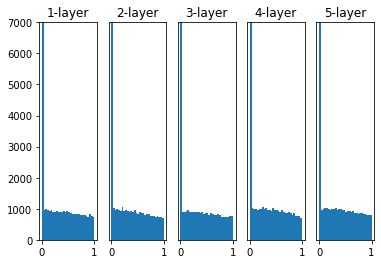

In [5]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    #w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    #w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    #z = sigmoid(a)
    z = ReLU(a)
    #z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


## MNISTによる比較

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from DLfromscratch.dataset.mnist import load_mnist

def smooth_curve(x):
    """損失関数のグラフを滑らかにするために用いる

    参考：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]

# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from collections import OrderedDict
from DLfromscratch.common.layers import *
from DLfromscratch.common.gradient import numerical_gradient


class MultiLayerNet:
    """全結合による多層ニューラルネットワーク

    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    weight_decay_lambda : Weight Decay（L2ノルム）の強さ
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 重みの初期化
        self.__init_weight(weight_init_std)

        # レイヤの生成
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """重みの初期値設定

        Parameters
        ----------
        weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
            'relu'または'he'を指定した場合は「Heの初期値」を設定
            'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値

            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        損失関数の値
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads


## 過学習

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from DLfromscratch.dataset.mnist import load_mnist

In [8]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True) #Mnistダウンロード

epoch:0, train acc:0.12, test acc:0.1155
epoch:1, train acc:0.15, test acc:0.1295
epoch:2, train acc:0.20666666666666667, test acc:0.1524
epoch:3, train acc:0.24333333333333335, test acc:0.1769
epoch:4, train acc:0.26, test acc:0.199
epoch:5, train acc:0.30666666666666664, test acc:0.2231
epoch:6, train acc:0.36333333333333334, test acc:0.2497
epoch:7, train acc:0.4, test acc:0.2818
epoch:8, train acc:0.42333333333333334, test acc:0.3088
epoch:9, train acc:0.45666666666666667, test acc:0.3281
epoch:10, train acc:0.48, test acc:0.349
epoch:11, train acc:0.5033333333333333, test acc:0.3623
epoch:12, train acc:0.5133333333333333, test acc:0.377
epoch:13, train acc:0.5333333333333333, test acc:0.399
epoch:14, train acc:0.57, test acc:0.4181
epoch:15, train acc:0.5733333333333334, test acc:0.4332
epoch:16, train acc:0.6066666666666667, test acc:0.4415
epoch:17, train acc:0.6133333333333333, test acc:0.4617
epoch:18, train acc:0.6333333333333333, test acc:0.4765
epoch:19, train acc:0.6333333

epoch:171, train acc:1.0, test acc:0.7489
epoch:172, train acc:1.0, test acc:0.7475
epoch:173, train acc:1.0, test acc:0.7481
epoch:174, train acc:1.0, test acc:0.7481
epoch:175, train acc:1.0, test acc:0.7487
epoch:176, train acc:1.0, test acc:0.7493
epoch:177, train acc:1.0, test acc:0.7487
epoch:178, train acc:1.0, test acc:0.746
epoch:179, train acc:1.0, test acc:0.7478
epoch:180, train acc:1.0, test acc:0.7472
epoch:181, train acc:1.0, test acc:0.7476
epoch:182, train acc:1.0, test acc:0.7472
epoch:183, train acc:1.0, test acc:0.7465
epoch:184, train acc:1.0, test acc:0.7478
epoch:185, train acc:1.0, test acc:0.7472
epoch:186, train acc:1.0, test acc:0.7477
epoch:187, train acc:1.0, test acc:0.7485
epoch:188, train acc:1.0, test acc:0.7506
epoch:189, train acc:1.0, test acc:0.7494
epoch:190, train acc:1.0, test acc:0.7513
epoch:191, train acc:1.0, test acc:0.7504
epoch:192, train acc:1.0, test acc:0.7501
epoch:193, train acc:1.0, test acc:0.7509
epoch:194, train acc:1.0, test acc:

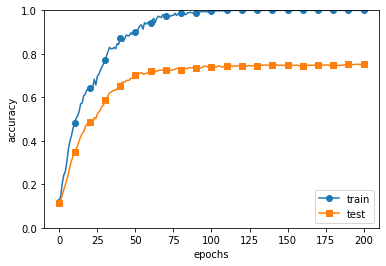

In [10]:
# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
weight_decay_lambda = 0 # weight decayを使用しない場合
#weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()